In [1]:
import torch
from torch import nn, optim
from neurodiffeq import diff
from neurodiffeq.networks import FCNN
from neurodiffeq.temporal import generator_2dspatial_rectangle, generator_2dspatial_segment, generator_temporal
from neurodiffeq.temporal import FirstOrderInitialCondition, BoundaryCondition
from neurodiffeq.temporal import SingleNetworkApproximator2DSpatialSystem, Approximator
from neurodiffeq.temporal import MonitorMinimal
from neurodiffeq.temporal import _solve_2dspatial
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri

In [2]:
RE = 100.0

def lid_driven_cavity(u, v, p, x, y):
    momentum_x = u*diff(u, x) + v*diff(u, y) + diff(p, x) - 1/RE * (diff(u, x, order=2) + diff(u, y, order=2))
    momentum_y = u*diff(v, x) + v*diff(v, y) + diff(p, y) - 1/RE * (diff(v, x, order=2) + diff(v, y, order=2))
    continuity = diff(u, x) + diff(v, y)
    return momentum_x, momentum_y, continuity

In [3]:
# boundary condition on u
u_bc_le = BoundaryCondition(
    form=lambda u, v, p, x, y: u,
    points_generator=generator_2dspatial_segment(size=32, start=(0.0, 0.0), end=(0.0, 1.0))
)
u_bc_ri = BoundaryCondition(
    form=lambda u, v, p, x, y: u,
    points_generator=generator_2dspatial_segment(size=32, start=(1.0, 0.0), end=(1.0, 1.0))
)
u_bc_up = BoundaryCondition(
    form=lambda u, v, p, x, y: u - 1.0,
    points_generator=generator_2dspatial_segment(size=32, start=(0.0, 1.0), end=(1.0, 1.0))
)
u_bc_lo = BoundaryCondition(
    form=lambda u, v, p, x, y: u,
    points_generator=generator_2dspatial_segment(size=32, start=(0.0, 0.0), end=(1.0, 0.0))
)

# boundary condition on v
v_bc_le = BoundaryCondition(
    form=lambda u, v, p, x, y: v,
    points_generator=generator_2dspatial_segment(size=32, start=(0.0, 0.0), end=(0.0, 1.0))
)
v_bc_ri = BoundaryCondition(
    form=lambda u, v, p, x, y: v,
    points_generator=generator_2dspatial_segment(size=32, start=(1.0, 0.0), end=(1.0, 1.0))
)
v_bc_up = BoundaryCondition(
    form=lambda u, v, p, x, y: v,
    points_generator=generator_2dspatial_segment(size=32, start=(0.0, 1.0), end=(1.0, 1.0))
)
v_bc_lo = BoundaryCondition(
    form=lambda u, v, p, x, y: v,
    points_generator=generator_2dspatial_segment(size=32, start=(0.0, 0.0), end=(1.0, 0.0))
)

# pressure point constraint on p
def p_gen():
    while True:
        yield torch.tensor([0.0]), torch.tensor([0.0])
p_bc = BoundaryCondition(
    form=lambda u, v, p, x, y: p,
    points_generator=p_gen()
)

# training set and validation set
train_gen_spatial = generator_2dspatial_rectangle(
    size=(32, 32), x_min=0.0, x_max=1.0, y_min=0.0, y_max=1.0
)
valid_gen_spatial = generator_2dspatial_rectangle(
    size=(10, 10), x_min=0.0, x_max=1.0, y_min=0.0, y_max=1.0, random=False
)

fcnn = FCNN(n_input_units=2, n_output_units=3, n_hidden_units=256, n_hidden_layers=1, actv=nn.Tanh)
fcnn_approximator = SingleNetworkApproximator2DSpatialSystem(
    single_network=fcnn,
    pde=lid_driven_cavity,
    boundary_conditions=[
        u_bc_le, u_bc_ri, u_bc_up, u_bc_lo,
        v_bc_le, v_bc_ri, v_bc_up, v_bc_lo,
        p_bc
    ],
    boundary_strictness=0.1
)

adam = optim.Adam(fcnn_approximator.parameters(), lr=0.001)

<IPython.core.display.Javascript object>


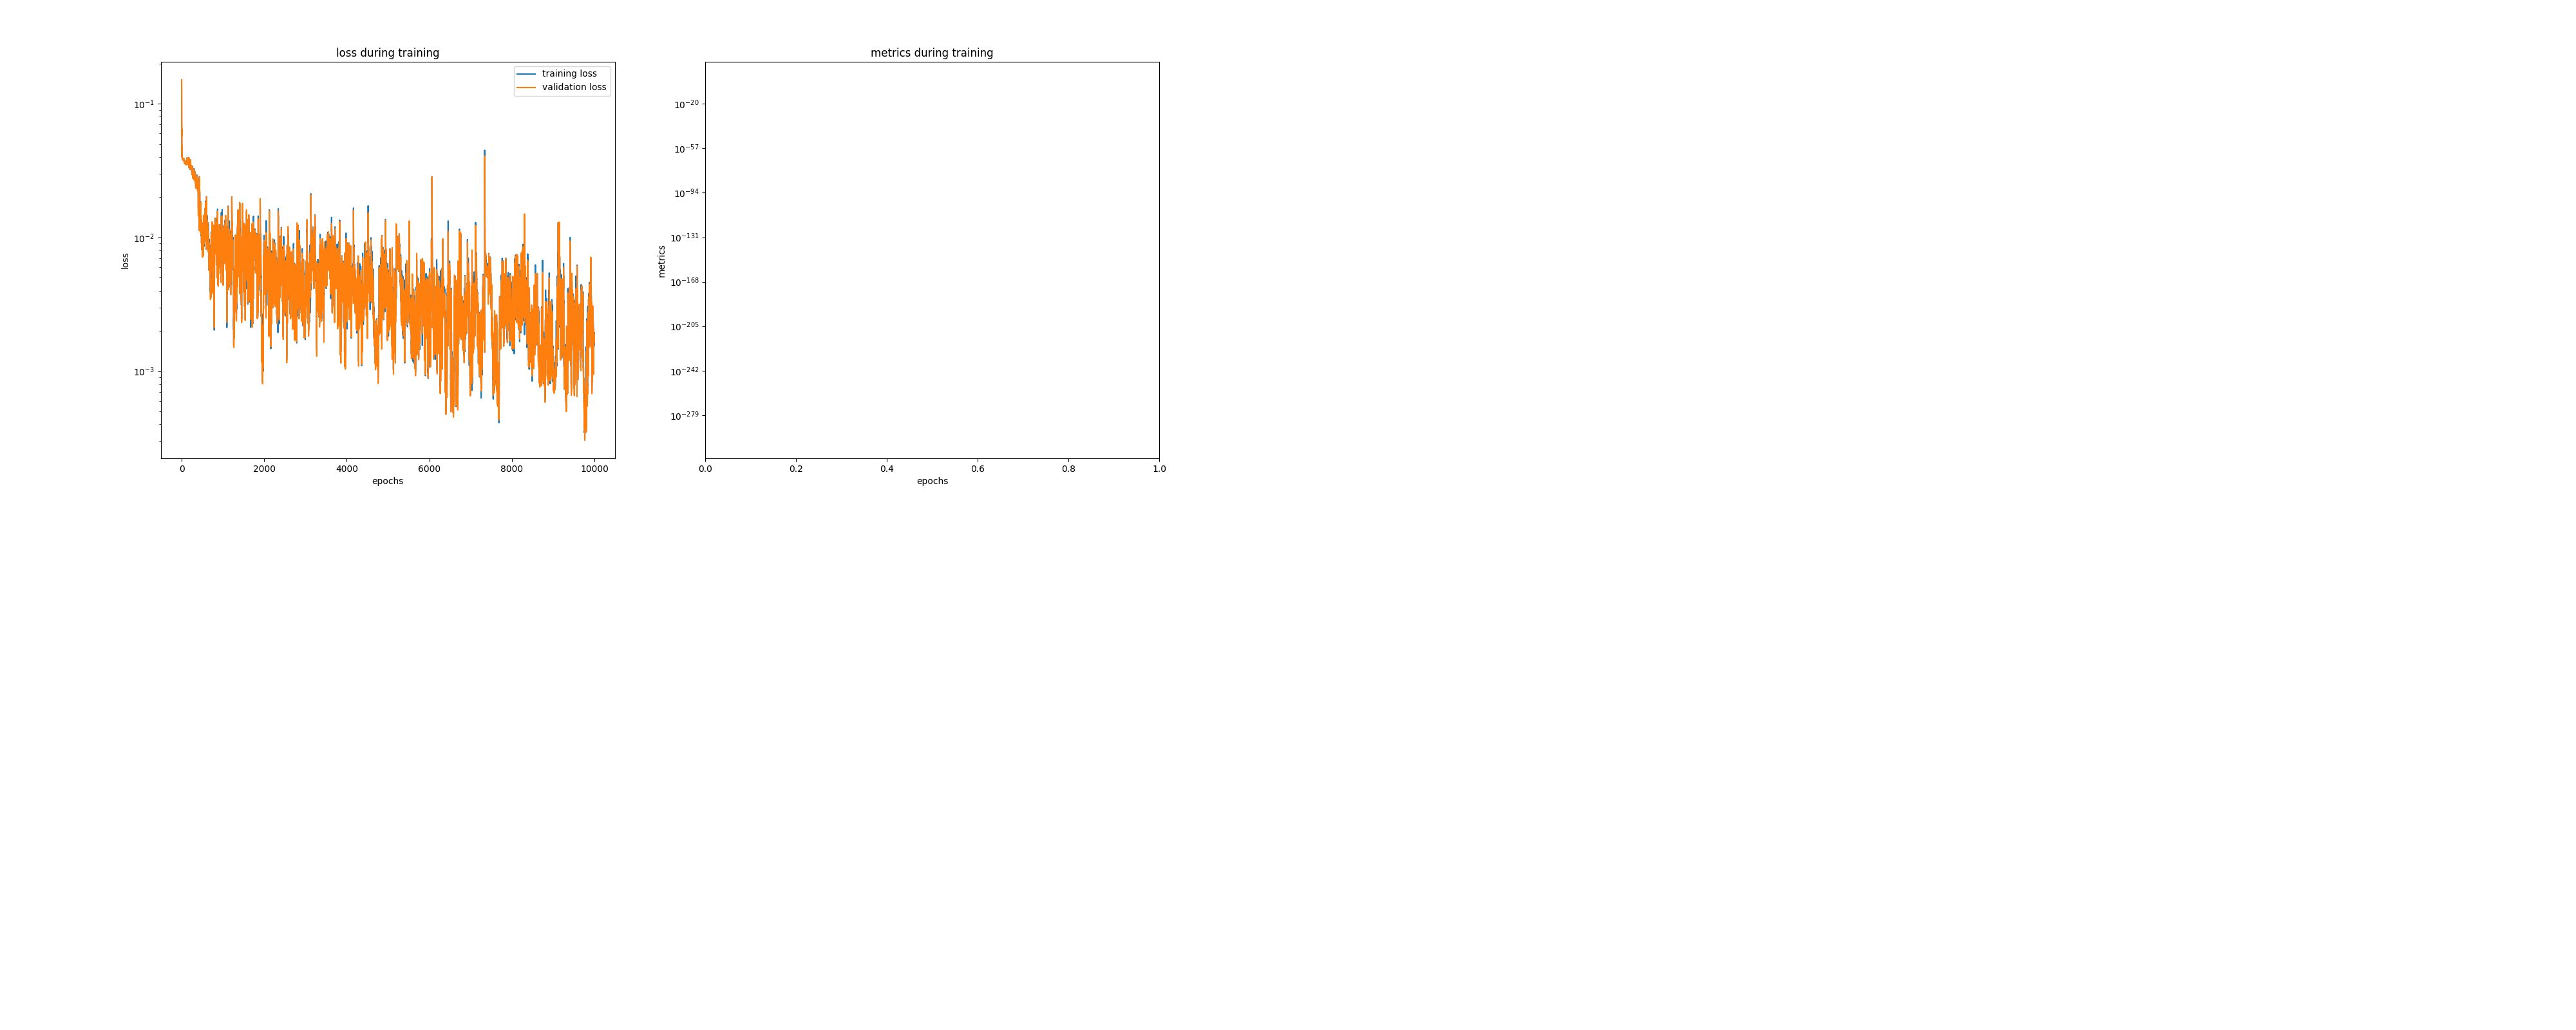

In [4]:
%matplotlib notebook
lid_driven_cavity_solution, _ = _solve_2dspatial(
    train_generator_spatial=train_gen_spatial,
    valid_generator_spatial=valid_gen_spatial,
    approximator=fcnn_approximator,
    optimizer=adam,
    batch_size=256,
    max_epochs=10000,
    shuffle=True,
    metrics={},
    monitor=MonitorMinimal(check_every=10)
)
%matplotlib inline

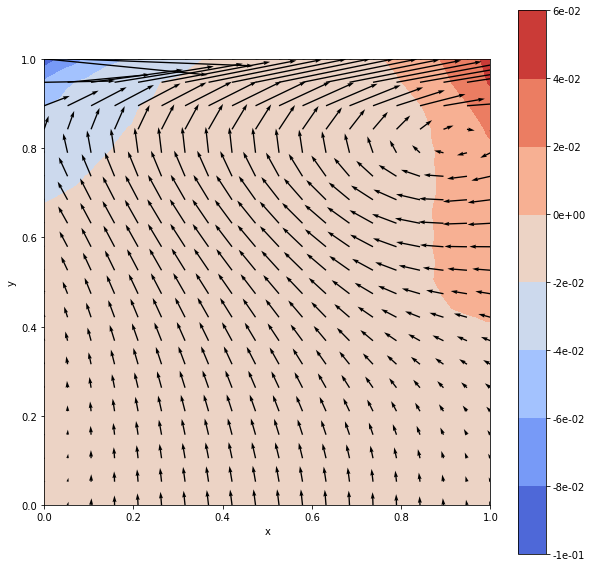

In [5]:
xx, yy = torch.meshgrid(torch.linspace(0,1,20), torch.linspace(0,1,20))
xx = xx.flatten()
yy = yy.flatten()
uu, vv, pp = lid_driven_cavity_solution(xx, yy)

xx = xx.detach().numpy()
yy = yy.detach().numpy()
uu = uu.detach().numpy()
vv = vv.detach().numpy()
pp = pp.detach().numpy()

fig = plt.figure(figsize=(10, 10))
ax = plt.gca()

triang = tri.Triangulation(xx, yy)
contour = ax.tricontourf(triang, pp, cmap='coolwarm')
fig.colorbar(contour, format='%.0e', ax=ax)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_aspect('equal', adjustable='box')

xx = xx.reshape(20, 20)
yy = yy.reshape(20, 20)
uu = uu.reshape(20, 20)
vv = vv.reshape(20, 20)
ax.quiver(xx, yy, uu, vv, scale=2)

plt.show()